<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Read_Ultrasound_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/Shareddrives/BreastUS'



'''
top_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
csv_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/'


#output patch save dir
patch_normal_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL'
patch_actionable_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/ACTIONABLE' 
patch_benign_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/BENIGN'
patch_cancer_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER'
'''

     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 132 kB 5.1 MB/s 
Mounted at /content/gdrive


"\ntop_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' \ncsv_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/'\n\n\n#output patch save dir\npatch_normal_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL'\npatch_actionable_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/ACTIONABLE' \npatch_benign_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/BENIGN'\npatch_cancer_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER'\n"

In [6]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [4]:
#Load a dicom image and convert it using dcm_read to get view type (needs this 
#to correctly align image))

csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')
data_files = os.listdir(annotated_dir)


label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)



#sample_dicom = os.path.join(dicom_dir,dicom_files[0]) #for now, just use first

#!ls '/content/gdrive/Shareddrives/BreastUS'

In [7]:
#READ CSV FILES
#pull out the box information and label info
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('_final' in csv_file):
        annotation_fields, annotation_rows = get_csv_data(filename)

    else:
        print('Non-archive file found ',filename)

found rows: 8843
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated.csv


In [42]:
annotation_fields

print(np.shape(annotation_rows))

print(annotation_fields)

array_rows = np.array(annotation_rows)
mrn = array_rows[:,1]
accession = array_rows[:,2]
video_id = array_rows[:,3]
frame_id = array_rows[:,4]
image_path = array_rows[:,5]


(8842, 11)
['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']


drive/MyDrive/Annotated data/unzipped_updated/1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip/default/frame_000000.PNG
/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_076up782_a_dcc4675o_0.mp4-2021_09_03_16_33_59-labelme 3.0.zip/default/frame_000000.PNG
filename exists:  True
(600, 800, 3)


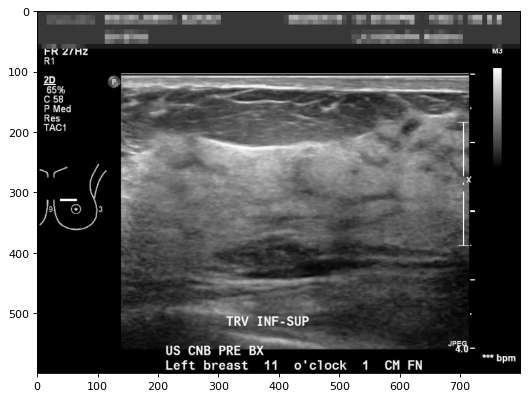

0.0
64
(array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 106, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
       584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
       597, 598, 599]),)
[[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   2 455   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1]]
----> (array([0]), array([41]))
41
--- 106


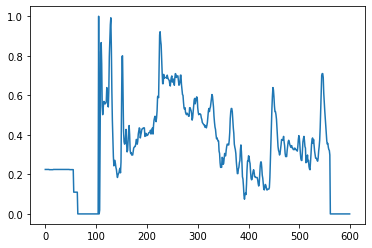

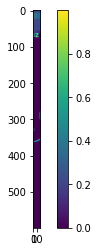

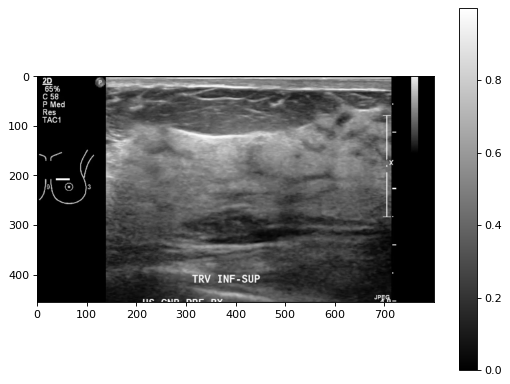

In [106]:
num_mrn = set(mrn)
num_mrn
image_path[0:3]

print(image_path[0])
filename = os.path.basename(image_path[0]) 
[_,fpath] =image_path[0].split('drive/MyDrive/Annotated data/')
full_file = os.path.join(annotated_dir,fpath)
print(full_file)

print('filename exists: ',os.path.exists(full_file))
import imageio

import PIL
from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)

from matplotlib import image
from matplotlib import pyplot
image = image.imread(full_file)
print(np.shape(image))


## Convert the RGB input into grayscale
R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(imgGray, cmap='gray')
plt.show()


## Look for coordinates to cut the US data out of the image overlay

nrows, ncols = np.shape(imgGray)
middle_column = np.uint(ncols/2)
middle_row = np.uint(nrows/2)

print(imgGray[80,400])

fig= plt.figure()
#ax = fig.plot(imgGray[80,:])
plt.plot(imgGray[:,middle_column])
#plt.ylim([0,0.02])

plt.figure()
plt.imshow(imgGray[:,70:90])
plt.colorbar()




#find the 0 gaps before and after the image on the column
data_strip = imgGray[:,middle_column]
index = np.where(data_strip == 0) #find first section of 0 values
print(index[0][0])
first_row_gap = index[0][0]
print(index)
print(np.diff(index))
diff_row = np.diff(index)
#find the large jump in diff, that will likely be US image then down to background 0
second_row_gap = np.where(diff_row >= 200)
print('---->',second_row_gap)
print(second_row_gap[1][0])
print('---',index[0][second_row_gap[1][0]])
low_row = index[0][second_row_gap[1][0]]
high_row = index[0][second_row_gap[1][0]+1] 

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(imgGray[low_row:high_row,:], cmap='gray')
plt.colorbar()


In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
full_file = os.path.join(label_data_dir, label_files[0])
with ZipFile(full_file, 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   for fnames in listOfFileNames:
       print(fnames)

default/frame_000045.PNG
default/item_000000052.xml
default/frame_000027.PNG
default/item_000000033.xml
default/frame_000042.PNG
default/frame_000057.PNG
default/frame_000025.PNG
default/item_000000007.xml
default/item_000000031.xml
default/frame_000049.PNG
default/frame_000022.PNG
default/frame_000041.PNG
default/frame_000051.PNG
default/item_000000055.xml
default/item_000000011.xml
default/item_000000032.xml
default/frame_000036.PNG
default/frame_000052.PNG
default/item_000000022.xml
default/item_000000034.xml
default/item_000000018.xml
default/item_000000035.xml
default/frame_000028.PNG
default/item_000000004.xml
default/frame_000054.PNG
default/frame_000005.PNG
default/frame_000021.PNG
default/item_000000040.xml
default/item_000000036.xml
default/item_000000001.xml
default/frame_000056.PNG
default/item_000000003.xml
default/item_000000029.xml
default/item_000000045.xml
default/frame_000038.PNG
default/frame_000017.PNG
default/item_000000008.xml
default/frame_000059.PNG
default/fram